# Fiddle Tutorial

This colab walks through how to use Fiddle, using Flax and JAX as a motivating example. This tutorial includes an overview of the key Fiddle APIs, best practices, as well as a few tips/tricks.

**Important note**: Fiddle has no dependency on Flax or JAX and can be used with arbitrary other Python libraries (TensorFlow, PyTorch, Lingvo, or even non-machine-learning libraries such as Flask). We just find that Fiddle happens to work especially well for machine learning applications, which tend to have a lot of hyperparameters---often nested in complex ways---with strict reproduciblity standards.

> Note to the reader: use the outline feature in Colab to easily navigate between the different sections of this tutorial.

## Imports

We first import Fiddle, and then JAX and Flax as normal. Nothing special here...

In [ ]:
!pip install fiddle

import fiddle as fdl

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn

## Building a Model

Here, we use JAX and Flax to define our working example. When starting out in a new codebase, we recommend _not_ using Fiddle. Instead, just write your code "normally"; Fiddle is designed to be gradually added to a codebase when the codebase has scaled (either in size or in number of concurrent users) to justify adding the dependency.

> This Fiddle design principle is related to the concept of "progressive disclosure of complexity", where you only need to pay for conceptual overhead when it is a worthwhile tradeoff.

In [ ]:
class MySimpleClassifierModel(nn.Module):
  # Just a standard Flax module; nothing special to see here.

  # Note: instead of instantiating child modules in `__init__` or `setup`, we
  # simply ask for them to be provided by the caller. While this is not strictly
  # necessary, this enables additonal flexibility in the future.
  dense1: nn.Dense
  dropout: nn.Dropout
  dense2: nn.Dense

  def __call__(self, x):
    x = self.dense1(x)
    x = jax.nn.relu(x)
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [ ]:
# Use our module _without_ Fiddle
def make_model():
  return MySimpleClassifierModel(
      dense1 = nn.Dense(features=10),
      dropout = nn.Dropout(rate=0.3),
      dense2 = nn.Dense(features=1),
  )

model = make_model()
model

MySimpleClassifierModel(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    dropout = Dropout(
        # attributes
        rate = 0.3
        broadcast_dims = ()
        deterministic = None
    )
    dense2 = Dense(
        # attributes
        features = 1
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

## Adding Fiddle

While the motivating code is perfectly usable as-is (and can be easily edited as needed to try alternative experiments), it will eventually become cumbersome to try myriad experiments to tune hyperparameters (e.g. the dropout rate, or the intermediate sizes of dense layers) when working with multiple collaborators.

Instead, we will add Fiddle to make it easy to _fiddle_ with the hyperparmaters. You can set parameters in a variety of ways (using property notation, kwargs, or positional arguments), as demonstrated below.

In [ ]:
# Rewrite `make_model` to return a `fdl.Config` instead.
def make_model_config():
  dense1 = fdl.Config(nn.Dense)
  dense1.features = 10  # Set values using property notation.
  dropout = fdl.Config(nn.Dropout, rate=0.3)  # Works via kwargs too.
  dense2 = fdl.Config(nn.Dense, 1)  # Positional arguments also work!
  return fdl.Config(MySimpleClassifierModel, dense1, dropout, dense2)

> Note: You can use `fiddle.experimental.auto_config` to avoid rewriting `make_model`. Please see the [`auto_config` tutorial][auto_config] for more details.

[auto_config]: https://colab.sandbox.google.com/github/google/fiddle/blob/main/fiddle/examples/colabs/auto_config.ipynb

### Using your Fiddle Config

Once you have a Fiddle `Config`, you can either mutate it, or call `fdl.build` to instantiate (recursively) configured objects.

In [ ]:
cfg = make_model_config()
cfg.dropout.deterministic = True
model = fdl.build(cfg)
model

MySimpleClassifierModel(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    dropout = Dropout(
        # attributes
        rate = 0.3
        broadcast_dims = ()
        deterministic = True
    )
    dense2 = Dense(
        # attributes
        features = 1
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

### Use it like normal

Once you've called `fdl.build` you now have a normal object with no references to `fdl` whatsoever. We thus have a normal Flax module that can be `init`'d and `apply`'d.

In [ ]:
BATCH_SIZE = 10
INPUT_FEATURES = 25
sample_input = jnp.zeros((BATCH_SIZE, INPUT_FEATURES))
rng = jax.random.PRNGKey(42)

thetas = model.init(rng, sample_input)
predictions = model.apply(thetas,
                          jax.random.uniform(rng, (BATCH_SIZE, INPUT_FEATURES)))
predictions

DeviceArray([[-0.31825894],
             [-0.18107423],
             [-0.27587453],
             [-0.47995874],
             [-0.2335658 ],
             [-0.46246213],
             [-0.17029431],
             [-0.6591648 ],
             [-0.46428704],
             [-0.4804871 ]], dtype=float32)

## Autocomplete in Colab/Jupyter

Fiddle Config objects are designed to be easily used in both checked-in code, as well as in interactive environments such as notebooks and the Python REPL.

You can see available properties by calling `dir`, or by asking your notebook environment to suggest autocompletions. These autocompletions work for _arbitrarily deeply nested_ config instances.

In [ ]:
print(dir(cfg))  # See available properties.
# cfg.dense2.  # If you ask Colab to autocomplete, and select `features`, it will even tell you that it's an `int` property!

['dense1', 'dense2', 'dropout', 'name', 'parent']


## Fiddle patterns

Fiddle makes it easy to build arbitrarily sophisticated objects. Below are a few recipes that you may find useful, using Flax as a motivating example.

### Aliasing objects (parameter sharing)

Fiddle makes it easy to build models that share parameters. In normal Flax, you can share parameters by referencing the same module instance in multiple places within a model. Similarly, in Fiddle, you can share object instances by referencing the same `fdl.Config` instance in multiple places within a larger `Config`. In other words, there is a one-to-one correspondence between Config instances and the object instances they produce when built.

In [ ]:
cfg = make_model_config()
cfg.dense2 = cfg.dense1  # Share parameters!

model = fdl.build(cfg)
model.dense1 is model.dense2  # Prints `True`

True

### Copying configs (making clones of modules)

Assigning one config to multiple parameters results in only one object built, and aliasing references to it made. However, there are many times when you'd like to set up a `fdl.Config` object, and then make multiple copies of it. 

Simply use `copy.deepcopy` for a full clone of the entire tree (or, less commonly, `copy.copy` for a shallow copy). These work identically for `fdl.Config` (and `fdl.Partial`) objects as on normal objects.

In [ ]:
import copy

cfg = make_model_config()
cfg.dense1.dtype = jnp.bfloat16
cfg.dense2 = copy.deepcopy(cfg.dense1)

model = fdl.build(cfg)
print(model.dense1 is model.dense2)
model  # dtype is bfloat16 and features is 10 on both dense1 and dense2.

False


MySimpleClassifierModel(
    # attributes
    dense1 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = bfloat16
        precision = None
        kernel_init = init
        bias_init = zeros
    )
    dropout = Dropout(
        # attributes
        rate = 0.3
        broadcast_dims = ()
        deterministic = None
    )
    dense2 = Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = bfloat16
        precision = None
        kernel_init = init
        bias_init = zeros
    )
)

### Aliasing and copying together (parameter sharing in practice)

Dual encoder models often employ sophisticated parameter sharing schemes. More importantly, when developing them you might want to experiment with differing amounts of parameter sharing. Fiddle makes it really easy to fiddle with which parameters are shared!

In [ ]:
class DualEncoder(nn.Module):
  query_encoder: MySimpleClassifierModel
  document_encoder: MySimpleClassifierModel

  def encode_query(self, x):
    return self.query_encoder(x)

  def encode_document(self, x):
    return self.document_encoder(x)

  def __call__(self, query, document):
    return jnp.einsum(
        '...h,...h->...',
        self.encode_query(query),
        self.encode_document(document),
    )

dual_enc_cfg = fdl.Config(DualEncoder)
dual_enc_cfg.query_encoder = make_model_config()
dual_enc_cfg.query_encoder.dense2.features = 10  # Output an embedding space.
dual_enc_cfg.query_encoder.dropout.deterministic = True
dual_enc_cfg.document_encoder = dual_enc_cfg.query_encoder
dual_enc = fdl.build(dual_enc_cfg)

# Create a new vector representing document input.
sample_document = jax.random.uniform(jax.random.PRNGKey(1),
                                     (BATCH_SIZE, INPUT_FEATURES))

thetas = dual_enc.init(jax.random.PRNGKey(0), sample_input, sample_document)

# You'll see only parameters for 'query_encoder', because they are shared!
print("Param shapes:", jax.tree_map(lambda x: x.shape, thetas["params"]))

# Example "running" this model's forward pass:
dual_enc.apply(thetas, sample_input, sample_document)

Param shapes: FrozenDict({
    query_encoder: {
        dense1: {
            bias: (10,),
            kernel: (25, 10),
        },
        dense2: {
            bias: (10,),
            kernel: (10, 10),
        },
    },
})


DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

As an exercise for the reader, before peeking at the answer below, try building a `DualEncoder` that shares only the 2nd dense layer between the encoder and decoder, but uses different `dense1` layers.

In [ ]:
# Just modify the existing config; you only need to specify what's different!
# This makes it extremely easy to, as a reader of the code, determine what's
# changed between 2 experiments.
# (Note: if you needed the existing object to persist unmodified, just make a
# copy with `copy.deepcopy(duale_enc_cfg)` instead of modifying it directly.)
dual_enc_cfg.document_encoder = copy.deepcopy(dual_enc_cfg.query_encoder)
dual_enc_cfg.document_encoder.dense2 = dual_enc_cfg.query_encoder.dense2

less_shared_dual_enc = fdl.build(dual_enc_cfg)

thetas = less_shared_dual_enc.init(jax.random.PRNGKey(0), sample_input, sample_document)
# You'll see parameters for both document_encoder and query_encoder, but only
# will have `dense2` nested within it, because it's shared.
print("Param shapes:", jax.tree_map(lambda x: x.shape, thetas["params"]))

Param shapes: FrozenDict({
    document_encoder: {
        dense1: {
            bias: (10,),
            kernel: (25, 10),
        },
    },
    query_encoder: {
        dense1: {
            bias: (10,),
            kernel: (25, 10),
        },
        dense2: {
            bias: (10,),
            kernel: (10, 10),
        },
    },
})


### Collections and configs (variable-sized layers, such as Sequential)

You can easily use Python lists (or dictionaries) inside your Fiddle-configured Flax modules.

In [ ]:
from typing import Any, List

class Sequential(nn.Module):
  layers: List[Any]  # Either nn.Modules, or activation functions.

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
cfg = fdl.Config(Sequential)
cfg.layers = [
  fdl.Config(nn.Dense, features=4),
  nn.activation.gelu,  # Mix fiddle things and non-fiddle things!
  fdl.Config(nn.Dense, features=1),
  nn.activation.softmax,
]
model = fdl.build(cfg)
print("Model:\n", model)
result, thetas = model.init_with_output(rng, sample_input)
print("\nParam shapes:\n", jax.tree_map(lambda x: x.shape, thetas["params"]))
print("\nResult:\n", result)

Model:
 Sequential(
    # attributes
    layers = [Dense(
        # attributes
        features = 4
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    ), <function gelu at 0x7faa19d3eef0>, Dense(
        # attributes
        features = 1
        use_bias = True
        dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
    ), <function softmax at 0x7faa19d3f0e0>]
)

Param shapes:
 FrozenDict({
    layers_0: {
        bias: (4,),
        kernel: (25, 4),
    },
    layers_2: {
        bias: (1,),
        kernel: (4, 1),
    },
})

Result:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


## Fiddle Extensions

To make Fiddle users as productive as possible, Fiddle provides several extensions and features on top of the core data model.

In [ ]:
# Import the extra extensions

from fiddle import graphviz
from fiddle import printing
from fiddle import selectors
import fiddle.extensions.jax

fiddle.extensions.jax.enable()  # Nicer printout for JAX types; non-essential.


### Graphical Visualization

You can ask Fiddle to make a graphical visualization for a Fiddle configuration. This can be really helpful when trying to quickly understand an unfamiliar codebase, or to ensure an experiment is doing exactly what you expect.

> Note: by calling `fiddle.extensions.jax.enable()` you get a prettier visualization, but it is not required.

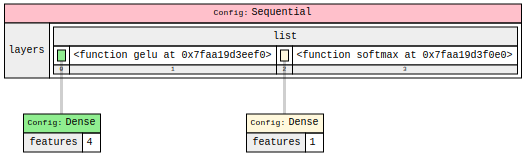

In [ ]:
graphviz.render(cfg)

Graphviz makes it very easy to see whether a config is shared between multiple parameters in a (hierarchical) configuration.

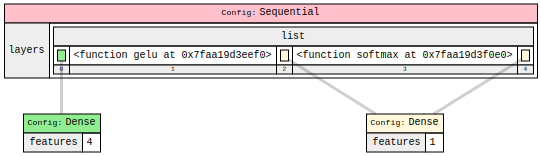

In [ ]:
cfg.layers.append(cfg.layers[2])  # Alias a layer.
graphviz.render(cfg)

### Changing values on multiple objects

Given that your model is composed of many modules, it can sometimes be helpful to change a setting across many different modules efficiently. For example, you may want to change the `DType` for every convolution layer to be `bfloat16` instead of `float32` for a given experiment.

You can do that easily using the `select` API.

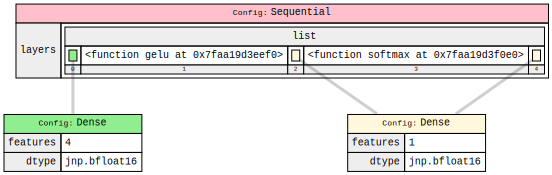

In [ ]:
selectors.select(cfg, nn.Dense).set(dtype=jnp.bfloat16)
graphviz.render(cfg)

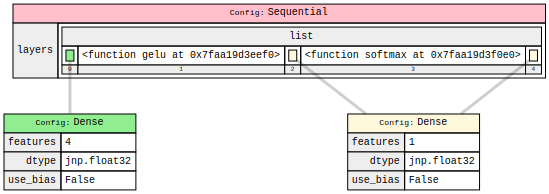

In [ ]:
# You can set multiple values in one operation as well.
selectors.select(cfg, nn.Dense).set(use_bias=False, dtype=jnp.float32)
graphviz.render(cfg)

For more information (and to learn about `fdl.TaggedValue`), check out the [select() and Tag APIs colab](https://colab.sandbox.google.com/github/google/fiddle/blob/main/fiddle/examples/colabs/select_and_tag_apis.ipynb).

### Time-travelling debugging

If, when you print out your model, a value is set to an unexpected value, you can easily determine when it got set thanks to the time-travelling debugging infrastructure! `printing.history_per_leaf_parameter` will print out, for each leaf parameter:

  1. the current value,
  2. where the current value was set (file (or notebook cell), line number, and function name (or `<module>` if set at the top-level) after the `@` sign), and
  3. all previous values (in reverse chronological order) including where they were set.

For additional information, check out the doc-strings for `printing` and each function.

In [ ]:
print(printing.history_per_leaf_parameter(cfg))

layers[0].features = 4 @ <ipython-input-14-d5dfc72e0365>:3:<module>
layers[0].dtype = <class 'jax._src.numpy.lax_numpy.float32'> @ /<src_root>/fiddle/experimental/selectors.py:107:set
  - previously: <class 'jax._src.numpy.lax_numpy.bfloat16'> @ /<src_root>/fiddle/experimental/selectors.py:107:set
layers[0].use_bias = False @ /<src_root>/fiddle/experimental/selectors.py:107:set
layers[0].bias_init = <[unset]>
layers[0].kernel_init = <[unset]>
layers[0].name = <[unset]>
layers[0].parent = <[unset]>
layers[0].precision = <[unset]>
layers[1] = <function gelu at 0x7faa19d3eef0>
layers[2].features = 1 @ <ipython-input-14-d5dfc72e0365>:5:<module>
layers[2].dtype = <class 'jax._src.numpy.lax_numpy.float32'> @ /<src_root>/fiddle/experimental/selectors.py:107:set
  - previously: <class 'jax._src.numpy.lax_numpy.bfloat16'> @ /<src_root>/fiddle/experimental/selectors.py:107:set
layers[2].use_bias = False @ /<src_root>/fiddle/experimental/selectors.py:107:set
layers[2].bias_init = <[unset]>
layers

### Grep-able/diff-able representations

Fiddle configs can be converted into a string that is easily machine-processable by standard unix tools such as `grep` and `diff`. It includes type annotations (if the corresponding classes include them), and also includes all unset parameters and their defaults (if available).

> Note: this format intentionally flattens out any aliased sub-configurations.

In [ ]:
print(printing.as_str_flattened(cfg))

layers[0].features: int = 4
layers[0].use_bias: bool = False
layers[0].dtype: typing.Any = <class 'jax._src.numpy.lax_numpy.float32'>
layers[0].precision: typing.Any = <[unset; default: None]>
layers[0].kernel_init: typing.Callable[[typing.Any, typing.Iterable[int], typing.Any], typing.Any] = <[unset; default: <function variance_scaling.<locals>.init at 0x7faa19fb1b00>]>
layers[0].bias_init: typing.Callable[[typing.Any, typing.Iterable[int], typing.Any], typing.Any] = <[unset; default: <function zeros at 0x7faa1a590680>]>
layers[0].parent: typing.Union[typing.Type[ForwardRef('Module')], typing.Type[ForwardRef('Scope')], typing.Type[ForwardRef('_Sentinel')], NoneType] = <[unset; default: <flax.linen.module._Sentinel object at 0x7faa19fe4d90>]>
layers[0].name: str = <[unset; default: None]>
layers[1] = <function gelu at 0x7faa19d3eef0>
layers[2].features: int = 1
layers[2].use_bias: bool = False
layers[2].dtype: typing.Any = <class 'jax._src.numpy.lax_numpy.float32'>
layers[2].precision:

## Beyond "single-file" programming

Fiddle has been designed with the complete software lifecycle in mind, from early experimentation to production-grade applications powered by machine learning models.

### ABSL Flags

Fiddle has an extension to integrate with [absl Flags](https://abseil.io/docs/python/guides/flags). To learn more, check out our [sample application](http://github.com/google/fiddle/tree/main/fiddle/absl_flags/example/) that includes recommended split of code between code files.

### Testing

TODO(saeta): Document when available.

## Integrations

Fiddle has been designed to interoperate with a number of existing configuration systems to support easy migration to (or from) Fiddle in an incremental fashion. To learn more about them, please see their respective documentation:

 - [Gin Config](TODO)
 - [Lingvo Params](TODO)